In [25]:
# Only bp on weight matrix, to find out what the final solution should be like
# Do backprop on each datapoint, better than backprop for each epoch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_wt import SimpleNeuralNetwork
from tqdm import tqdm

In [26]:
# load the pickle file
with open('weights_abb05_wt.pkl', 'rb') as f:
    model_wt = pickle.load(f)
    losses = pickle.load(f)
    weight_sums = pickle.load(f)
    weights = pickle.load(f)
epochs = len(losses)

In [27]:
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

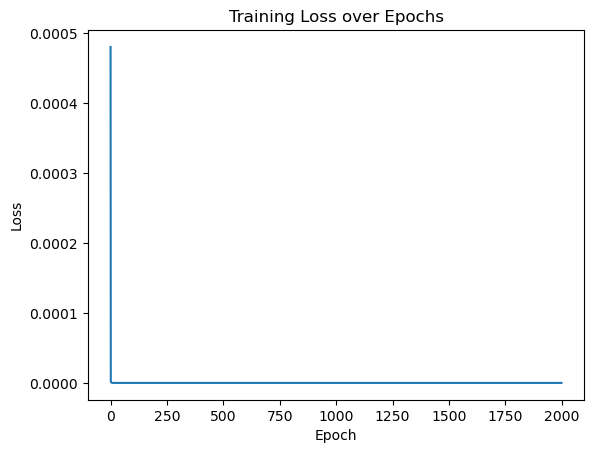

In [28]:
# Plotting the loss
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.1])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

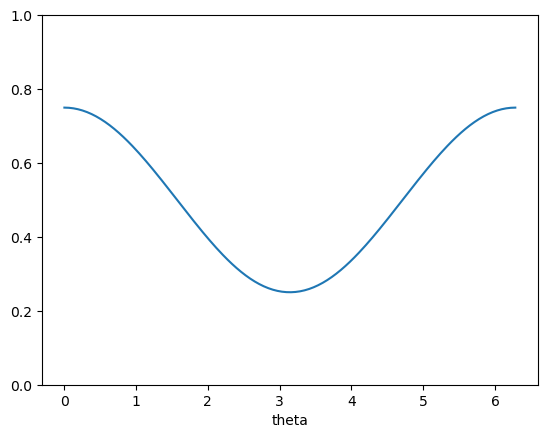

In [29]:
# Plotting the outputs
model_wt.eval()
outputs = []
for x in xs:
    output = model_wt(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

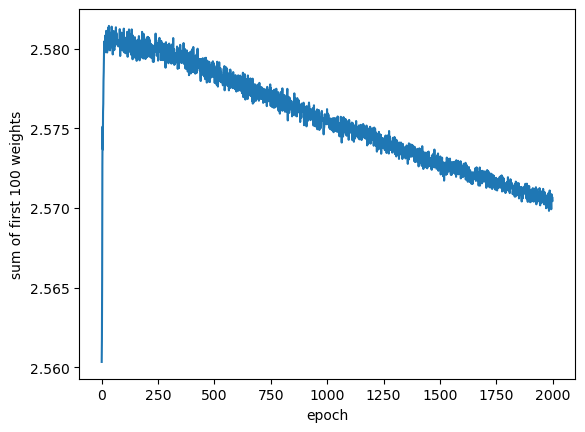

In [30]:
plt.plot(np.arange(epochs), weight_sums)
# plt.ylim([0,8])
plt.xlabel("epoch")
plt.ylabel("sum of first 100 weights")
# plt.savefig('abb05_ws.png')
plt.show()

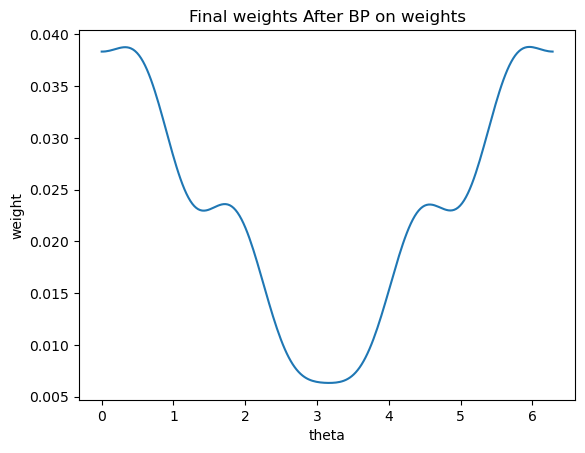

In [31]:
final_weight = weights[-1].flatten()
plt.plot(np.linspace(0, 2 * np.pi, model_wt.input_size), final_weight)
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
plt.title("Final weights After BP on weights")
plt.savefig('fig/0122_abb05_wt_weights.png')
plt.show()

In [32]:
1 / np.linalg.norm(final_weight, None)**2

6.600114145027885

In [33]:
rates = []
for x in xs:
    input = model_wt.gaussian_rf(x)
    rate = model_wt.activation_func(model_wt.gain * (input - model_wt.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.5   , 0.4996, 0.4985, ..., 0.4985, 0.4996, 0.5   ],
       [0.4997, 0.5   , 0.4995, ..., 0.4969, 0.4987, 0.4997],
       [0.4989, 0.4998, 0.5   , ..., 0.4948, 0.4972, 0.4989],
       ...,
       [0.4989, 0.4972, 0.4948, ..., 0.5   , 0.4998, 0.4989],
       [0.4997, 0.4987, 0.4969, ..., 0.4995, 0.5   , 0.4997],
       [0.5   , 0.4996, 0.4985, ..., 0.4985, 0.4996, 0.5   ]],
      dtype=float32)

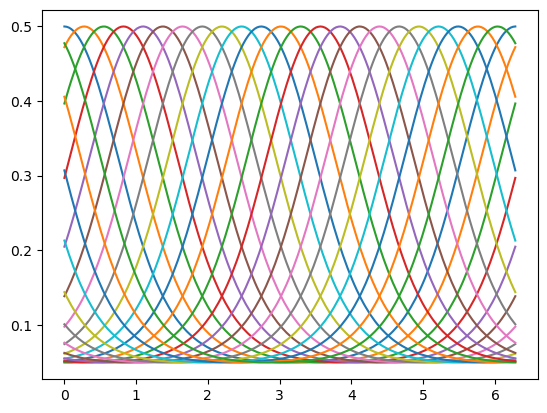

In [34]:
for i in np.arange(0,model_wt.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.show()

### Hebbian Coverge Test

Unfortunatelly, the Hebbian learning rule does not converge to the correct weights. The weights tend to flatten to a certain small curvature. This final convergence does not depend on hebbian learning rate. But ndata might have a bit influence.

In [35]:
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [36]:
# manual simulation
simu_epochs = 100
input_size = 230
init_gain = model_wt.gain.detach().numpy()
init_shift = model_wt.shift.detach().numpy()
init_weight = model_wt.weights.detach().numpy()
has_hebbian = True
hebbian_lr = 0.001
hebb_alpha = 5.5

simu_losses = []
simu_weight_sums = []

for epoch in tqdm(range(simu_epochs), position=0, leave=True):

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]

    epoch_loss = 0
    hebbian_update = torch.zeros_like(torch.tensor(init_weight))

    # establish model
    model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

    for x, y in zip(shuffled_xs, shuffled_ys):            
        actv_opl = model(x)
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        epoch_loss += loss
        # Calculate Hebbian weight updates
        hebbian_update += model.output_activation * (model.input_activation).T

    # update weights
    if has_hebbian:
        # Apply Hebbian updates and normalize
        model.weights = model.weights + hebbian_lr * hebbian_update
        model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
    # update init weights
    init_weight = model.weights.detach().numpy()

    # print losses
    epoch_loss /= ndata
    simu_losses.append(epoch_loss.item())
    simu_weight_sums.append(np.sum(init_weight))

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

 14%|█▍        | 14/100 [00:00<00:01, 66.16it/s]

Epoch: 0, Loss: 7.544688429561575e-09
Epoch: 10, Loss: 0.013044644147157669


 30%|███       | 30/100 [00:00<00:00, 70.13it/s]

Epoch: 20, Loss: 0.014546372927725315
Epoch: 30, Loss: 0.014629141427576542


 54%|█████▍    | 54/100 [00:00<00:00, 71.80it/s]

Epoch: 40, Loss: 0.01463358011096716
Epoch: 50, Loss: 0.01463381852954626


 70%|███████   | 70/100 [00:00<00:00, 71.90it/s]

Epoch: 60, Loss: 0.014633839018642902
Epoch: 70, Loss: 0.014633839949965477


 94%|█████████▍| 94/100 [00:01<00:00, 71.93it/s]

Epoch: 80, Loss: 0.014633838087320328
Epoch: 90, Loss: 0.014633837155997753


100%|██████████| 100/100 [00:01<00:00, 71.26it/s]


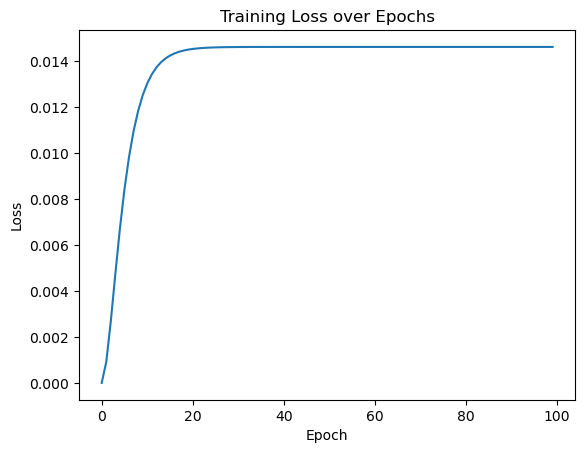

In [37]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(simu_losses)
plt.title('Training Loss over Epochs')
plt.savefig('fig/0122_abb05_wtconv_loss.png')

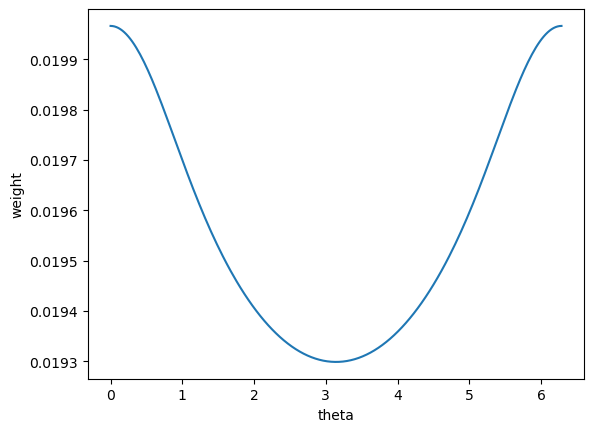

In [38]:
hebbian_update_np = hebbian_update.detach().numpy().flatten()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), hebbian_update_np * 0.001)
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

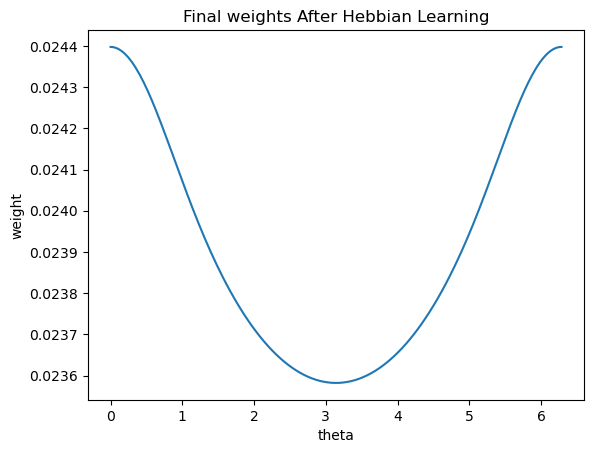

In [39]:
simu_weights = model.weights.detach().numpy().flatten()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), simu_weights)
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
plt.title("Final weights After Hebbian Learning")
plt.savefig('fig/0122_abb05_wtconv_weights.png')
plt.show()

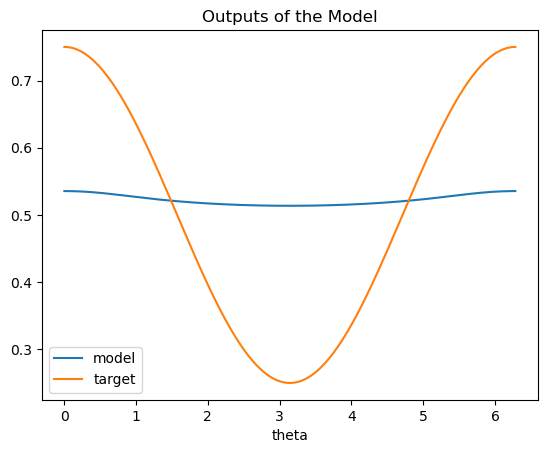

In [40]:
# Plotting the outputs
final_model = SimpleNeuralNetwork(model.input_size, model.init_gain.detach().numpy(), model.init_shift.detach().numpy(), simu_weights)
outputs = []
for x in xs:
    output = final_model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
# plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
plt.title("Outputs of the Model")
plt.savefig('fig/0122_abb05_wtconv_output.png')